In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import os

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report

2025-08-25 15:50:33.844461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756137034.038154      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756137034.091243      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [14]:
data_dir = '/kaggle/input/indonesian-sign-language-bisindo/bisindo/images'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

Found 9169 files belonging to 26 classes.
Using 7336 files for training.
Found 9169 files belonging to 26 classes.
Using 1833 files for validation.
Found 2301 files belonging to 26 classes.
Kelas yang ditemukan: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Jumlah kelas: 26


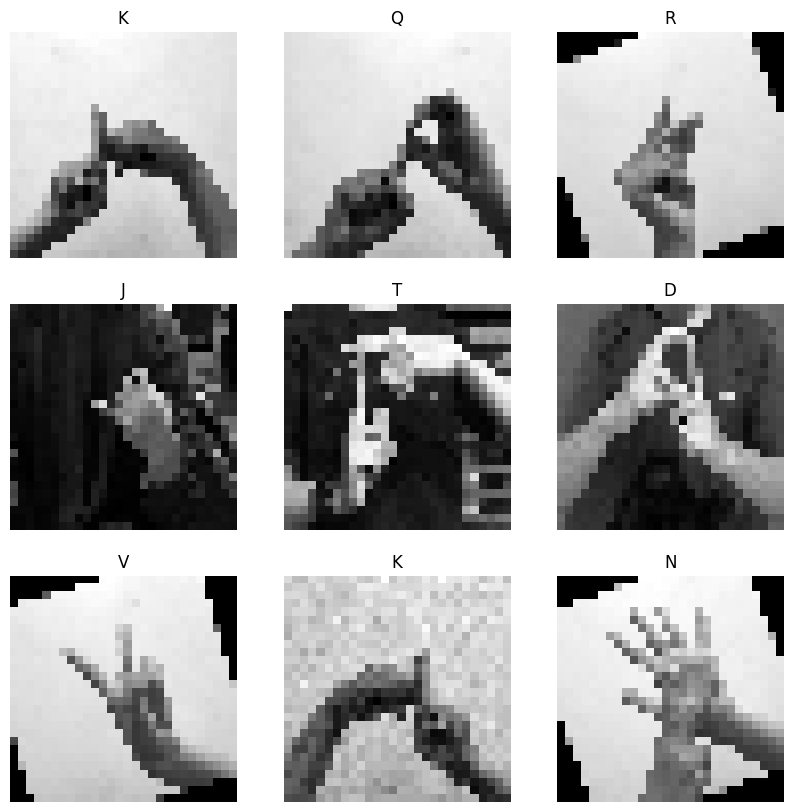

In [15]:
# Tentukan parameter untuk memuat gambar
IMG_HEIGHT = 28
IMG_WIDTH = 28
BATCH_SIZE = 32

# Menggunakan tf.keras.utils.image_dataset_from_directory untuk memuat data training dan validasi.
# Fungsi ini secara otomatis akan membaca gambar dari folder, memberi label, dan membuat batch.
# Kita akan memisahkan 20% dari data training untuk dijadikan data validasi.
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    validation_split=0.2, # 20% data untuk validasi
    subset='training',    # Menandakan ini adalah bagian training
    seed=123              # Seed untuk memastikan pemisahan data konsisten
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir, # Sumber data sama dengan training
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation', # Menandakan ini adalah bagian validasi
    seed=123
)

# Memuat data tes secara terpisah
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='grayscale',
    batch_size=BATCH_SIZE
)

# Mengambil nama-nama kelas (A, B, C, ...) dari dataset
class_names = train_dataset.class_names
print("Kelas yang ditemukan:", class_names)
print(f"Jumlah kelas: {len(class_names)}")


plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(images[i].numpy()), cmap='gray')
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

In [16]:
model = Sequential()
model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)))

# Normalisasi data menjadi [0, 1] sebagai layer pertama
model.add(Rescaling(1./255))

# Arsitektur CNN sama seperti sebelumnya
model.add(Conv2D(75, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(25, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(class_names), activation='softmax')) # Output layer disesuaikan dengan jumlah kelas

# Mengkonfigurasi proses training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 75)     │           750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 75)     │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 75)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 50)     │        33,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 50)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 25)       │        11,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 25)       │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 25)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 225)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       115,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,475 (685.45 KB)

 Trainable params: 175,175 (684.28 KB)

 Non-trainable params: 300 (1.17 KB)

In [17]:
# Callback untuk mengurangi learning rate jika performa stagnan
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

# Melatih model menggunakan dataset yang baru
# Kita tidak lagi menggunakan `datagen.flow()`
history = model.fit(
    train_dataset,
    epochs=20, # Anda bisa sesuaikan jumlah epoch
    validation_data=validation_dataset,
    callbacks=[learning_rate_reduction]
)


Epoch 1/20


I0000 00:00:1756137512.875109     105 service.cc:148] XLA service 0x7e6164012cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756137512.875831     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756137512.875855     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756137513.326731     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/230 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.0219 - loss: 4.3528    

I0000 00:00:1756137517.090229     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


230/230 ━━━━━━━━━━━━━━━━━━━━ 28s 86ms/step - accuracy: 0.3975 - loss: 2.3573 - val_accuracy: 0.0415 - val_loss: 3.8802 - learning_rate: 0.0010
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7565 - loss: 0.8847 - val_accuracy: 0.6661 - val_loss: 1.3173 - learning_rate: 0.0010
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8169 - loss: 0.6389 - val_accuracy: 0.8031 - val_loss: 0.7127 - learning_rate: 0.0010
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.8497 - loss: 0.5107 - val_accuracy: 0.8194 - val_loss: 0.6484 - learning_rate: 0.0010
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8854 - loss: 0.3777 - val_accuracy: 0.8342 - val_loss: 0.5882 - learning_rate: 0.0010
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.9094 - loss: 0.2956 - val_accuracy: 0.8178 - val_loss: 0.6805 - learning_rate: 0.0010
Epoch 7/20
228/230 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9244 - loss: 0.2290
Epoch

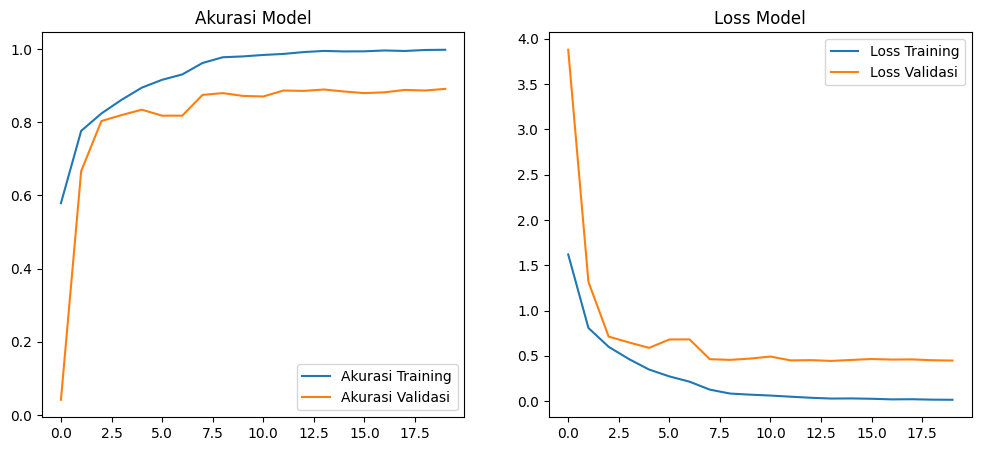


--- Mengevaluasi Model pada Data Tes ---
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.8809 - loss: 0.4512

Akurasi pada data tes: 88.31%


In [18]:
# Plotting Akurasi dan Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.legend()
plt.show()

# Evaluasi pada data tes
print("\n--- Mengevaluasi Model pada Data Tes ---")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\nAkurasi pada data tes: {test_accuracy*100:.2f}%")

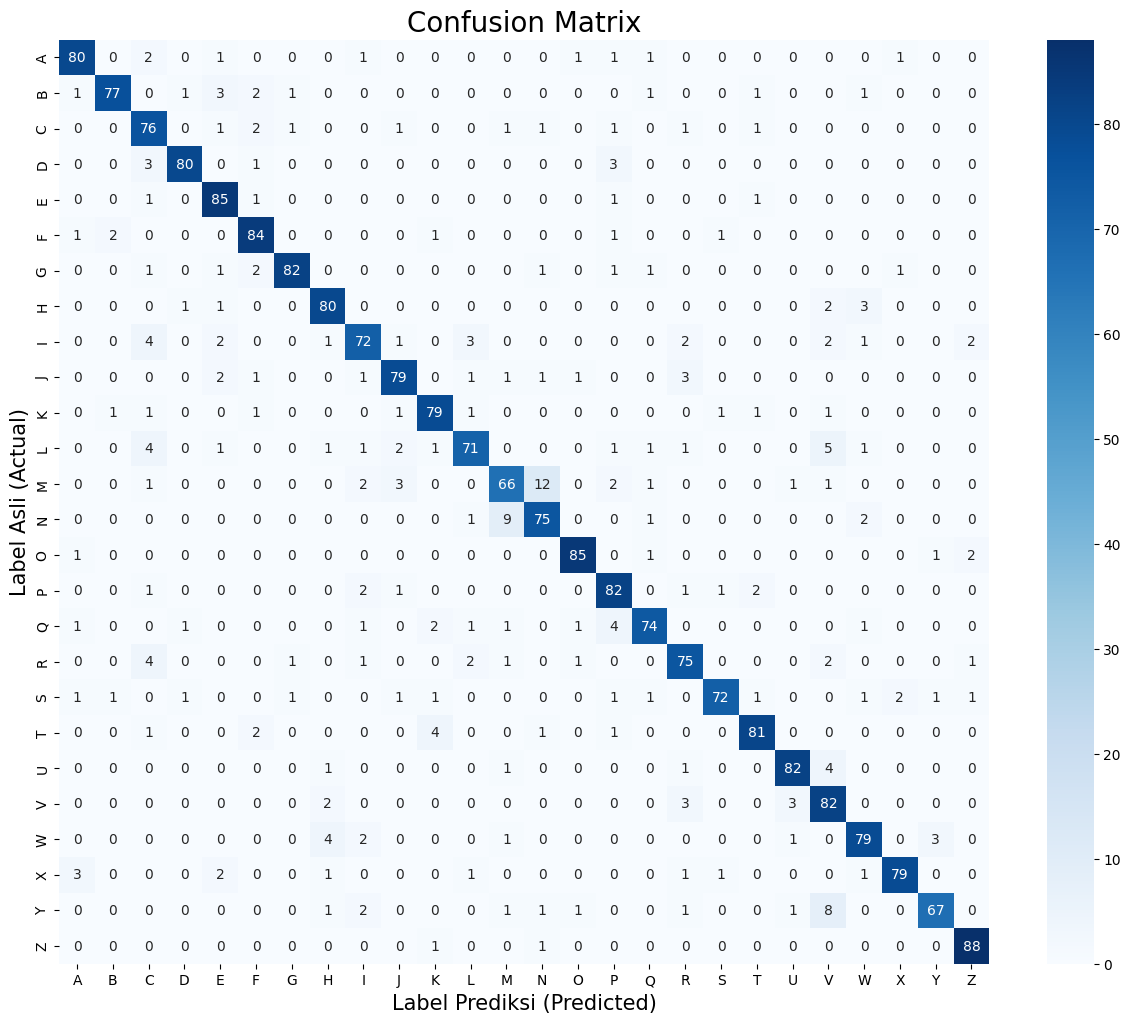


Laporan Klasifikasi (Classification Report):

              precision    recall  f1-score   support

           A       0.91      0.91      0.91        88
           B       0.95      0.88      0.91        88
           C       0.77      0.88      0.82        86
           D       0.95      0.92      0.94        87
           E       0.86      0.96      0.90        89
           F       0.88      0.93      0.90        90
           G       0.95      0.91      0.93        90
           H       0.88      0.92      0.90        87
           I       0.85      0.80      0.82        90
           J       0.89      0.88      0.88        90
           K       0.89      0.91      0.90        87
           L       0.88      0.79      0.83        90
           M       0.80      0.74      0.77        89
           N       0.81      0.85      0.83        88
           O       0.94      0.94      0.94        90
           P       0.83      0.91      0.87        90
           Q       0.90      0.85 

In [19]:
# Membuat Confusion Matrix dan Classification Report
y_pred_indices = []
y_true_indices = []
# Iterasi melalui test_dataset untuk mendapatkan semua label
for images, labels in test_dataset:
    predictions = model.predict(images, verbose=0)
    y_pred_indices.extend(np.argmax(predictions, axis=1))
    y_true_indices.extend(np.argmax(labels.numpy(), axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true_indices, y_pred_indices)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=20)
plt.ylabel('Label Asli (Actual)', fontsize=15)
plt.xlabel('Label Prediksi (Predicted)', fontsize=15)
plt.show()

# Classification Report
print("\nLaporan Klasifikasi (Classification Report):\n")
print(classification_report(y_true_indices, y_pred_indices, target_names=class_names))


In [20]:
bisindo_model = 'bisindo_cnn_model.h5'
model.save(bisindo_model)
print(f"Model telah berhasil disimpan sebagai: {bisindo_model}")

# Memuat kembali model (untuk demonstrasi)
loaded_model = load_model(bisindo_model)

Model telah berhasil disimpan sebagai: bisindo_cnn_model.h5



--- Memprediksi gambar: /kaggle/input/databaru12/v1.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


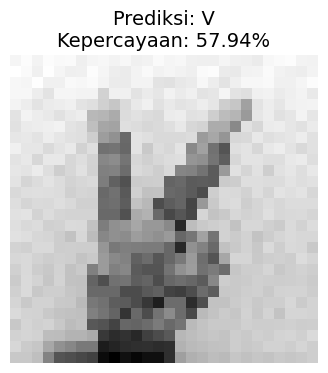

In [26]:
test_image_path = os.path.join(test_dir, '/kaggle/input/databaru12/v1.jpg') 

print(f"\n--- Memprediksi gambar: {test_image_path} ---")

img = load_img(test_image_path, color_mode="grayscale", target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = img_to_array(img)
img_for_prediction = np.expand_dims(img_array, axis=0) 

# Prediksi menggunakan model yang sudah dilatih
prediction_probabilities = loaded_model.predict(img_for_prediction)
predicted_index = np.argmax(prediction_probabilities)
confidence_score = np.max(prediction_probabilities) * 100
predicted_letter = class_names[predicted_index]

# Menampilkan hasil
plt.figure(figsize=(4, 4))
plt.imshow(img_array.squeeze(), cmap='gray')
plt.title(f"Prediksi: {predicted_letter}\nKepercayaan: {confidence_score:.2f}%", fontsize=14)
plt.axis('off')
plt.show()